# Iris Classification with Logistic Regression

In [129]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

## Dataset Inspection

Since the data is loaded using pandas, we can use methods such as `DataFrame.describe()` and `DataFrame.info()` to learn about the data. One thing to note here is that the original dataset does not come with headers and hence we also use the `names` attribute to create the headers based on the description of the dataset found in the `iris.names` file.

In [130]:
data = pd.read_csv("iris.data", names=["sepal_width", "sepal_length", "petal_length", "petal_width", "class"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_width   150 non-null    float64
 1   sepal_length  150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.3+ KB


The first thing we can notice is that although our features are numerical, the classification values are categorical (eg. Iris-Setosa). As such, for the purpose of model training, we could encode these classes into numerical values.

In [131]:
data.describe()

,sepal_width,sepal_length,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


As mentioned in the README file, the dataset is known to be relatively complete but if we were to go into this blindly, we could see based on these descriptions of the DataFrame that we don't have any missing data and that the data seems to make sense.

## Encoding the Classes

As previously mentioned, the original dataset has the categorical classes (eg. Iris-Setosa). As such, we could convert this into labels with values between 0 and n_classes - 1. In this case with 3 classes, we would have the following encoding:

0 - Iris-Setosa
1 - Iris Versicolour
2 - Iris Virginica

Encoding can easily be done using the `LabelEncoder` class from the sklearn package:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

By using the `fit_transfom()` method below, we fit the label encoder on the class column and get the encoded labels in return, allowing us to reassign the column with the encoded values.

In [132]:
encoder = LabelEncoder()
data["class"] = encoder.fit_transform(data["class"])

for id_, class_ in enumerate(encoder.classes_):
    print(f"Class {id_} corresponds to label {class_}")

Class 0 corresponds to label Iris-setosa
Class 1 corresponds to label Iris-versicolor
Class 2 corresponds to label Iris-virginica


## Data Visualization

We can also learn about the dataset by visualising the numerical values through the use of histograms. Once again, by using pandas, we have the benefit of easily using the `DataFrame.hist()` method to plot the histograms. Since the values in our dataset are all numerical, we don't need to do anything else but in case we had categorical data, we could also encode the data. (This comes in handy when it comes to our y values later)

We could use these histograms to identify outliers and erroneous values, prompting us to handle them prior to model training. 

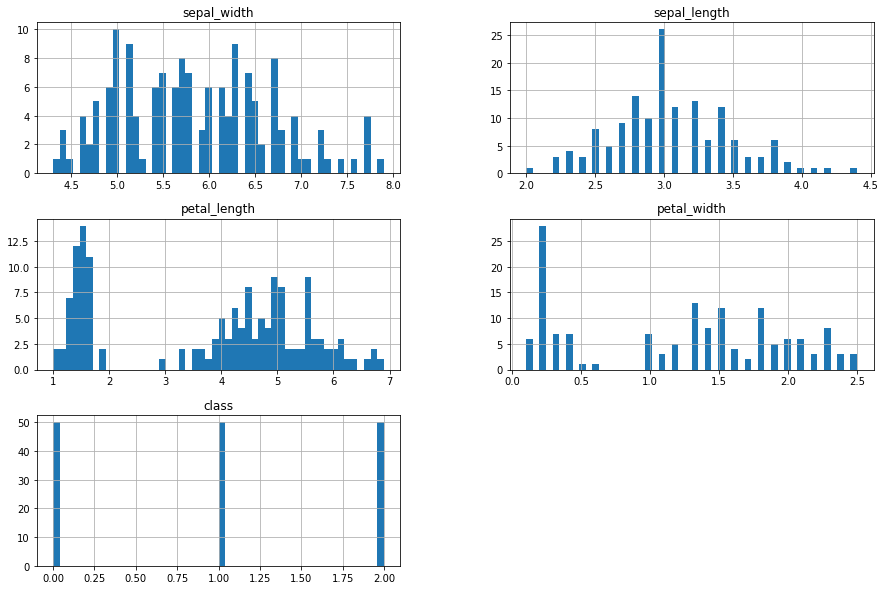

In [133]:
data.hist(bins=50, figsize=(15, 10))
plt.show()

Observations:

1. One major thing we can observe from these histograms is the difference in scales of the features. Although they are not too far off each other, mean normalization and feature scaling could be beneficial for model performance improvement.

2. The different peaks for the petal length and petal width could also indicate the distinction between the classes.

3. There doesn't seem to be any outstanding plots that could indicate outliers or presence of missing values.

4. There is also a balanced distribution of the classes with 50 examples for each class.

## Remove Duplicate Data Points

We now check through the dataset and remove duplicate entries to avoid overrepresentation of data points. We can do this using the `DataFrame.drop_duplicates()` method.

In [134]:
print("Shape of the data prior to duplicate removal:", data.shape)
duplicates_removed = data.drop_duplicates(keep="first")
print("Shape of the data after removing duplicates:", duplicates_removed.shape)

Shape of the data prior to duplicate removal: (150, 5)
Shape of the data after removing duplicates: (147, 5)


We can see that by the reduction in the number of rows of data, there were some data points that were duplicates and were removed. However, due to the nature of the domain, I do believe that it is possible that they could have been different examples that either coincidentally had exactly the same measurements (biologically rare case) or that the measurements did not include enough significant figures to account for minute differences. As such, for this dataset, I decided to remain with the original dataset for model training.

## Further Insight with Attribute Correlation

Another useful thing we could look at to further understand the data is the correlation between the features. For this case, we can compute Pearson's correlation coefficient which is described as follows:

> Pearson's correlation coefficient is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

This correlation can be computed using the `DataFrame.corr()` method.

In [135]:
correlation_matrix = data.corr(method='pearson')
correlation_matrix

,sepal_width,sepal_length,petal_length,petal_width,class
sepal_width,1.000000,-0.109369,0.871754,0.817954,0.782561
sepal_length,-0.109369,1.000000,-0.420516,-0.356544,-0.419446
petal_length,0.871754,-0.420516,1.000000,0.962757,0.949043
petal_width,0.817954,-0.356544,0.962757,1.000000,0.956464
class,0.782561,-0.419446,0.949043,0.956464,1.000000


In [136]:
correlation_matrix["class"].sort_values()

sepal_length   -0.419446
sepal_width     0.782561
petal_length    0.949043
petal_width     0.956464
class           1.000000
Name: class, dtype: float64

By taking a look at how each feature correlates with the classification, we can see that most of the features have high positive correlation with the class variable.

## Splitting the Dataset into Training and Test Sets

Splitting the dataset into training and test sets allow us to set aside a test set that is not used for training and is instead used for evaluation of the trained model. This allows us to see if our model is able to generalise to examples not seen previously and to check whether overfitting is occurring. A common practice is to have an 80/20 split. We would normally also have a cross validation set to tune the hyperparameters but in this case, with only few examples, we made do without.

Creating the splits can be easily done using the sklearn package which includes a `train_test_split()` method. I also opted to shuffle the dataset as the original had the classes ordered. (It wouldn't make sense only to validate on the third class, especially if this means that not many examples of it were used for training)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [137]:
X = np.array(data[data.columns[0:4]])
y = np.array(data["class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (120, 4)
Test set shape: (30, 4)


## Model Training

For this multiclass classification, I used the Logistic Regression model provided by scikit learn.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [138]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

## Model Validation

With the trained model, we can finally test the accuracy on both the training set and the test set. Note that the results can vary based on the shuffling of the dataset but overall, the accuracies tend to lie above 90%.

We can also get the classification report of the model which gives us the precision and recall metrics along with the F score.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Lastly, we can also plot the confusion matrix to summarize the model's ability in making predictions. This can show us where the model makes classification errors.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

Accuracy with Training Set: 95.83333333333334%
Accuracy with Test Set: 96.66666666666667%

Training Set Classification Report 
               precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        42
 Versicolour       0.93      0.95      0.94        41
   Virginica       0.94      0.92      0.93        37

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

Test Set Classification Report 
               precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         8
 Versicolour       0.90      1.00      0.95         9
   Virginica       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



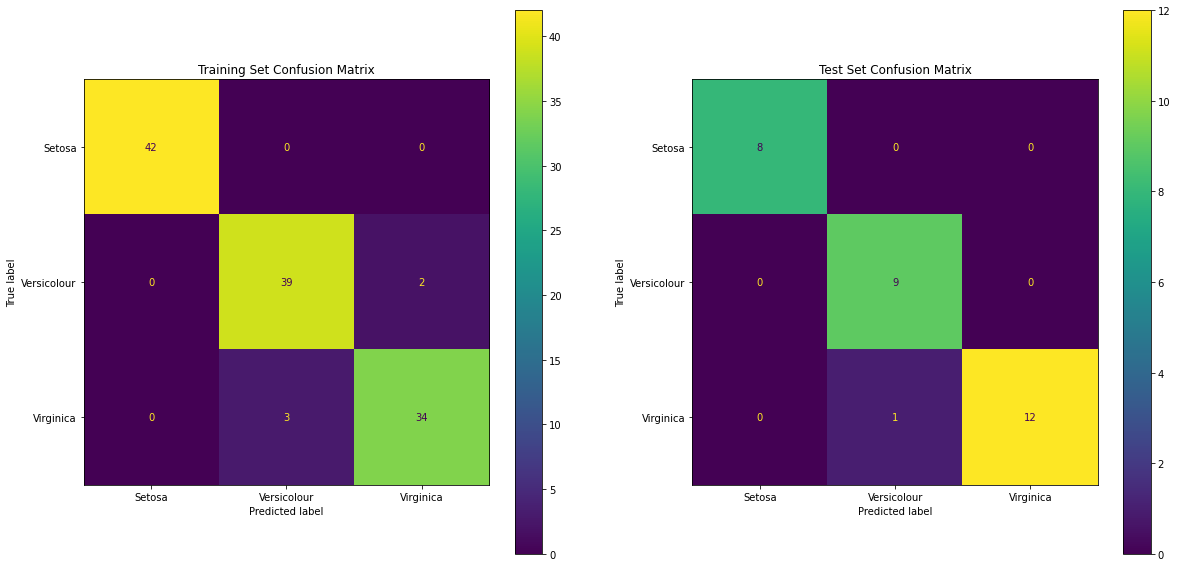

In [142]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_accuracy = np.mean(y_train == pred_train)
test_accuracy = np.mean(y_test == pred_test)

print(f"Accuracy with Training Set: {train_accuracy*100}%")
print(f"Accuracy with Test Set: {test_accuracy*100}%")
print()

original_labels = ["Setosa", "Versicolour", "Virginica"]

training_report = classification_report(y_train, pred_train, target_names=original_labels)
test_report = classification_report(y_test, pred_test, target_names=original_labels)
print("Training Set Classification Report \n", training_report)
print("Test Set Classification Report \n", test_report)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
plot_confusion_matrix(model, X_train, y_train, ax=axes[0], display_labels=original_labels)
plot_confusion_matrix(model, X_test, y_test, ax=axes[1], display_labels=original_labels)

axes[0].title.set_text("Training Set Confusion Matrix")
axes[1].title.set_text("Test Set Confusion Matrix")

plt.show()